# Notebook that demonstrates the use of the UF23 model

In [1]:
# to import the gmf.py, this cell should be only executed once after kernel restart
%cd ..

C:\Users\friba\Desktop\Bachelorarbeit\gammaALPs


In [2]:
from gammaALPs.bfields import gmf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

In [3]:
import matplotlib as mpl
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

## Build coordinate arrays

In [4]:
x = np.arange(-20., 20.1, 0.1)
y = np.arange(-20., 20.1, 0.1)
z = np.arange(-10., 10.02, 0.02)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

In [5]:
rr = np.sqrt(np.power(xx, 2) + np.power(yy, 2))
pp = np.arctan2(yy, xx)

In [6]:
print(rr.shape)

(401, 401, 1001)


## Initialize GMF model

Initialze the UF23 class with one of 8 models (see https://arxiv.org/abs/2311.12120)

In [7]:
models = ['base', 'expX', 'neCL', 'twistX', 'nebCor', 'cre10', 'synCG', 'spur']
model = 'neCL'

In [8]:
uf23_models = []

for mod in models:
    uf23_models.append(gmf.UF23(model=mod))

In [9]:
uf23_models

In [10]:
uf23 = gmf.UF23(model=model)

In [11]:
spur = gmf.UF23(model='spur')

## Disk component

In [12]:
zplot = 0
idz = np.absolute(z-zplot).argmin()
print(idz)

500


In [13]:
# Bdisk = np.zeros_like(rr[...,idz])
Bdisk = np.zeros((8, *rr[...,idz].shape))

In [14]:
for k in range(len(models)):
    for i,r in enumerate(rr[...,idz]):
        # returns (3,N),(N) tuple, first entry is field, second entry is abs value
        b = uf23_models[k].Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
        Bdisk[k][:,i] = b[1] * gmf.signum(b[0][1,:])

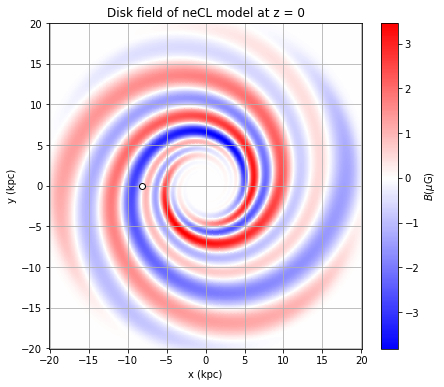

In [15]:
plt.figure(figsize=(7,6))

k=2
norm = TwoSlopeNorm(vmin=Bdisk[k].min(), vcenter=0, vmax=Bdisk[k].max())
p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk[k], norm=norm, cmap = plt.cm.bwr, shading='auto')

plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')
plt.title(f"Disk field of {models[k]} model at z = {zplot}")

plt.plot(-8.2, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()

#### For the spur model:

In [16]:
Bdisk_spur = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = spur.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk_spur[:,i] = b[1] * gmf.signum(b[0][1,:])

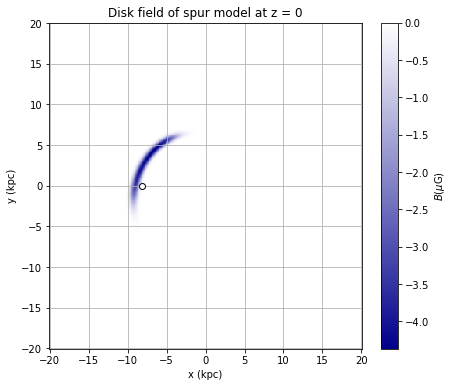

In [17]:
plt.figure(figsize=(7,6))
cmap0 = LinearSegmentedColormap.from_list('', ['darkblue', 'white'])

p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk_spur, cmap = cmap0, shading='auto')

plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')
plt.title(f"Disk field of spur model at z = {zplot}")

plt.plot(-8.2, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()

## Toroidal halo component

Only phi component

In [18]:
yplot = 0
idy = np.absolute(y-yplot).argmin()
print(idy)

200


In [19]:
Bhalo_tor = np.zeros((len(models), *xx[:, idy, :].shape))
k = 2
for i,xi in enumerate(xx[:,idy,:]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = uf23_models[k].toroidal_halo_field(rho=np.sqrt(xi**2. + y[idy]**2.), z=zz[i,idy,:]) 
    Bhalo_tor[k][i,:] = b[1] * gmf.signum(b[0][1,:])

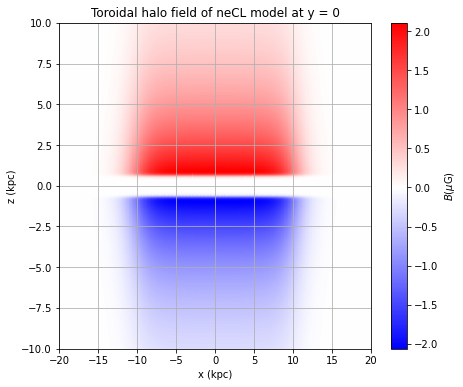

In [20]:
plt.figure(figsize=(7,6))

norm = TwoSlopeNorm(vmin=Bhalo_tor[k].min(), vcenter=0, vmax=Bhalo_tor[k].max())
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo_tor[k], norm=norm, cmap = plt.cm.bwr, shading='auto')

plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')
plt.title(f"Toroidal halo field of {model} model at y = {yplot}")

plt.grid()

plt.show()

## Poloidal halo component

Only r and z component

In [21]:
yplot = 0
idy = np.absolute(y-yplot).argmin()
print(idy)

200


In [22]:
BX = np.zeros([3] + list(xx[:,idy,:].shape))
BX_abs = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    b = uf23.poloidal_halo_field(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    BX_abs[i,:] = b[1]
    BX[:, i, :] = b[0]

In [23]:
# convert to cartesian coordinates, phi component is zero
BX_x = BX[0] * np.cos(pp[:,idy,...])
BX_y = BX[0] * np.sin(pp[:,idy,...])

BX_z = BX[2]
BX_abss = np.where(BX_abs == 0, 1e-24, BX_abs)

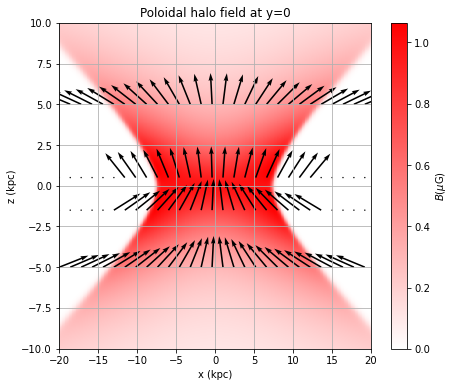

In [24]:
cmap0 = LinearSegmentedColormap.from_list('', ['white', 'red'])
plt.figure(figsize=(7,6))

p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], BX_abs, cmap=cmap0, shading='auto')

plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

z0 = 0.5
idz = np.absolute(z-z0).argmin()
# print(idz, z[idz])
step = 14
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abss[:,idz][::step], BX_z[:,idz][::step] / BX_abss[:,idz][::step],
           width=5e-3, scale=10
          )

z0 = -1.5
idz = np.absolute(z-z0).argmin()
# print(z[idz])
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abss[:,idz][::step], BX_z[:,idz][::step] / BX_abss[:,idz][::step],
           width=5e-3, scale=10
          )

z0 = -5
idz = np.absolute(z-z0).argmin()
# print(z[idz])
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abss[:,idz][::step], BX_z[:,idz][::step] / BX_abss[:,idz][::step],
           width=5e-3, scale=10
          )

z0 = 5
idz = np.absolute(z-z0).argmin()
# print(z[idz])
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abss[:,idz][::step], BX_z[:,idz][::step] / BX_abss[:,idz][::step],
           width=5e-3, scale=10
          )
# plt.streamplot(xx[:,idy,:], zz[:,idy,:], BX_x, BX_z, broken_streamlines=False, density=0.35)

plt.title(f'Poloidal halo field at y={yplot}')
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.grid()

plt.show()

## Twisted halo field

In [25]:
twistx = gmf.UF23(model="twistX")

In [26]:
def field_line(x_0, steps, ds):
    x = np.zeros((steps, 3))
    x[0] = x_0
    for i in range(steps-1):
        x[i+1] = integrate(x[i], ds)
    return x

def integrate(x_prev, ds):
    '''Returns next point along field line, given some starting point x_prev and a small increment ds'''
    r, phi, z = cart_to_cyl(x_prev[0], x_prev[1], x_prev[2])
    # print(r, phi, z)
    B_sph = twistx.Bhalo(np.array([r]), np.array([z]))[0]
    B_cart = trafo(B_sph, x_prev[0]/r, x_prev[1]/r).transpose()
    norm = np.linalg.norm(B_cart)
    x_new = x_prev + B_cart / norm * ds
    return x_new


def cart_to_cyl(x, y, z):
    '''Coordinate transformation from cartesian to spherical.'''
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    z = z
    return r, phi, z

def cyl_to_cart(r, phi, z):
    '''Coordinate transformation from spherical to cartesian'''
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    z = z
    return x, y, z

def trafo(v, cos_phi, sin_phi):
    """
    Converts cylindrical coordinates to cartesian coordinates.
    Arguments:
    v : array_like
        Cylindrical coordinates vector (r, theta, z)
    cos_phi : float
        Cosine of the angle phi
    sin_phi : float
        Sine of the angle phi
    
    Returns:
    numpy array representing the Cartesian coordinates (x, y, z)
    """
    return np.array([v[0] * cos_phi - v[1] * sin_phi,
                     v[0] * sin_phi + v[1] * cos_phi,
                     v[2]
                     ])

def norm(r):
    return np.sqrt(r[:, :, :, 0]**2)


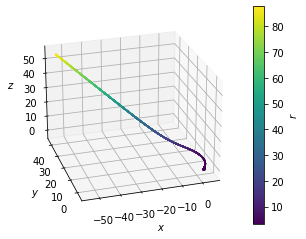

In [27]:
# %matplotlib notebook    
# so that we can have an interactive plot!

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')


# start a field line at r=0.2, theta=pi / 2 (on the equator), phi=0
# choose some stepsize ds=0.001 and integrate 100000 steps

ds = 0.001
steps = 100000

r = 4
z = -2


for phi in np.linspace(0, 2 * np.pi, num=1):
    x_0 = cyl_to_cart(r, phi, z)
    x = field_line(x_0, steps, ds)
    #print(x)
    #plot only every 10th point to save memory and time
    line = ax.scatter(x[::10, 0], x[::10, 1], x[::10, 2],
                      c=np.linalg.norm(x[::10], axis=1),
                      cmap=plt.get_cmap('viridis'),
                      s=1, marker='.')
cbar = fig.colorbar(line, ax=ax, label='$r$')
# ax.set_xticks((-0.5, 0, 0.5))
# ax.set_yticks((-0.5, 0, 0.5))
# ax.set_zticks((-0.4, 0, 0.4))
ax.view_init(elev=25, azim=-107)
